In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

In [2]:
import pandas as pd, numpy as np, os, sys
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from IPython.display import display, HTML

font = {'size'   : 18}
matplotlib.rc('font', **font)

def plotHorizontalBars(series, xlabel, title):
    xpos = np.arange(len(series.index), 0, -1)
    plt.barh(xpos, series, align='center', alpha=0.5, color='g')
    plt.grid(axis='x')
    plt.yticks(xpos, series.index)
    plt.xlabel(xlabel)
    plt.title(title)

def plotVerticalBars(series, ylabel, title):
    xpos = np.arange(len(series.index), 0, -1)
    plt.bar(xpos, series, align='center', alpha=0.5, color='g')
    plt.grid(axis='y')
    plt.xticks(xpos, series.index)
    plt.ylabel(ylabel)
    plt.title(title)

In [3]:
import ssl, re
ssl._create_default_https_context = ssl._create_unverified_context
pd.__version__

'0.24.2'

In [4]:
# on Github, open CSV file and click on 'Raw'. Copy URL

filename = 'time_series_19-covid-Confirmed.csv'
data_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'+filename
ts_df = pd.read_csv(data_url)
ts_df = ts_df[~ts_df['Province/State'].astype(str).map(lambda x: re.search('Diamond Princess', x) is not None)]
ts_df = ts_df[~ts_df['Province/State'].astype(str).map(lambda x: re.search('Grand Princess', x) is not None)]
ts_df = ts_df.sort_values(['Country/Region', 'Province/State'])
print(ts_df['Country/Region'].unique())
display(ts_df)

['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Aruba' 'Australia' 'Austria' 'Azerbaijan'
 'Bahrain' 'Bangladesh' 'Belarus' 'Belgium' 'Bhutan' 'Bolivia'
 'Bosnia and Herzegovina' 'Brazil' 'Brunei' 'Bulgaria' 'Burkina Faso'
 'Cambodia' 'Cameroon' 'Canada' 'Cayman Islands' 'Chile' 'China'
 'Colombia' 'Congo (Kinshasa)' 'Costa Rica' "Cote d'Ivoire" 'Croatia'
 'Cuba' 'Cyprus' 'Czechia' 'Denmark' 'Dominican Republic' 'Ecuador'
 'Egypt' 'Estonia' 'Ethiopia' 'Finland' 'France' 'French Guiana' 'Georgia'
 'Germany' 'Greece' 'Guadeloupe' 'Guinea' 'Guyana' 'Holy See' 'Honduras'
 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq' 'Ireland' 'Israel'
 'Italy' 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan' 'Kenya' 'Korea, South'
 'Kuwait' 'Latvia' 'Lebanon' 'Liechtenstein' 'Lithuania' 'Luxembourg'
 'Malaysia' 'Maldives' 'Malta' 'Martinique' 'Mexico' 'Moldova' 'Monaco'
 'Mongolia' 'Morocco' 'Nepal' 'Netherlands' 'New Zealand' 'Nigeria'
 'North Macedonia' 'Norway'

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20
26,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1,1,1,1,4,4,5,7,7,7
97,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,0,0,0,0,0,2,10,12,23,33
29,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,12,12,17,17,19,20,20,20,24,26
61,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
419,NaN,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
67,NaN,Argentina,-38.4161,-63.6167,0,0,0,0,0,0,...,1,1,2,8,12,12,17,19,19,31
57,NaN,Armenia,40.0691,45.0382,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,4,8
416,NaN,Aruba,12.5211,-69.9683,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
405,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,...,22,22,26,28,38,48,55,65,65,92


In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

lin_df = ts_df.drop(['Lat', 'Long', 'Province/State'], axis=1)
lin_df = lin_df.groupby('Country/Region').sum().transpose()
lin_df['date_count'] = [i for i in range(lin_df.shape[0])]
display(lin_df.tail(7))

Country/Region,Afghanistan,Albania,Algeria,Andorra,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,Austria,Azerbaijan,Bahrain,Bangladesh,Belarus,Belgium,Bhutan,Bolivia,Bosnia and Herzegovina,Brazil,Brunei,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Cayman Islands,Chile,China,Colombia,Congo (Kinshasa),Costa Rica,Cote d'Ivoire,Croatia,Cuba,Cyprus,Czechia,Denmark,Dominican Republic,Ecuador,Egypt,Estonia,Ethiopia,Finland,France,French Guiana,Georgia,Germany,Greece,Guadeloupe,Guinea,Guyana,Holy See,Honduras,Hungary,Iceland,India,Indonesia,Iran,Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,"Korea, South",Kuwait,Latvia,Lebanon,Liechtenstein,Lithuania,Luxembourg,Malaysia,Maldives,Malta,Martinique,Mexico,Moldova,Monaco,Mongolia,Morocco,Nepal,Netherlands,New Zealand,Nigeria,North Macedonia,Norway,Oman,Pakistan,Panama,Paraguay,Peru,Philippines,Poland,Portugal,Qatar,Reunion,Romania,Russia,San Marino,Saudi Arabia,Senegal,Serbia,Singapore,Slovakia,Slovenia,South Africa,Spain,Sri Lanka,Sudan,Sweden,Switzerland,Taiwan*,Thailand,Togo,Tunisia,Turkey,US,Ukraine,United Arab Emirates,United Kingdom,Vietnam,date_count
3/7/20,1,0,17,1,0,8,1,0,63,79,9,85,0,6,169,1,0,3,13,0,0,0,1,1,54,0,4,80770,1,0,1,0,12,0,0,19,24,2,13,15,10,0,15,952,5,4,799,46,0,0,0,1,0,4,50,34,4,5823,54,18,43,5883,0,461,1,0,0,7041,61,1,22,1,1,2,93,0,3,2,6,0,1,0,2,1,188,5,1,3,147,16,6,0,0,1,6,5,20,8,0,9,13,23,5,4,1,138,1,7,1,500,1,0,161,268,45,50,1,1,0,336,1,45,207,18,45
3/8/20,4,0,19,1,0,12,1,0,76,104,9,85,3,6,200,1,0,3,20,0,4,0,2,2,64,0,8,80823,1,0,5,0,12,0,0,31,37,5,14,49,10,0,23,1129,5,13,1040,73,0,0,0,1,0,7,50,39,6,6566,60,19,61,7375,0,502,1,0,0,7314,64,2,32,1,1,3,99,4,3,2,7,1,1,0,2,1,265,5,1,3,176,16,6,0,1,6,10,11,30,15,0,15,17,36,11,4,1,150,3,16,3,673,1,0,203,337,45,50,1,2,0,452,1,45,274,30,46
3/9/20,4,2,20,1,0,12,1,0,91,131,9,95,3,6,239,1,0,3,25,1,4,0,2,2,77,0,8,80860,1,0,9,0,12,0,2,31,92,5,15,55,10,0,30,1212,5,15,1176,73,0,0,0,1,0,9,58,43,19,7161,60,21,61,9172,0,511,1,0,0,7478,64,6,32,1,1,3,117,4,3,2,7,1,1,0,2,1,321,5,2,3,205,16,6,0,1,7,20,16,30,18,0,15,17,36,15,4,1,150,3,16,3,1073,1,0,248,374,45,50,1,2,0,517,1,45,322,30,47
3/10/20,5,10,20,1,0,17,1,0,107,182,11,110,3,9,267,1,0,5,31,1,4,1,2,2,79,0,13,80887,3,0,9,0,14,0,3,41,264,5,15,59,12,0,40,1787,5,15,1457,89,0,0,0,1,0,9,69,56,27,8042,71,34,83,10149,0,581,1,0,0,7513,69,8,41,1,1,5,129,6,5,2,7,3,1,1,3,1,382,5,2,7,400,18,16,1,1,11,33,22,41,24,0,25,20,51,20,4,5,160,7,31,7,1695,1,0,355,491,47,53,1,5,0,892,1,74,384,31,48
3/11/20,7,12,20,1,0,19,1,0,128,246,11,195,3,9,314,1,2,7,38,11,7,2,3,2,108,0,23,80921,9,1,13,1,19,0,6,91,444,5,17,60,16,0,59,2284,5,24,1908,99,0,0,0,1,2,13,85,62,34,9000,71,43,109,12462,1,639,1,0,0,7755,72,10,61,1,3,7,149,8,6,3,8,3,1,1,5,1,503,5,2,7,598,18,19,8,5,11,49,31,59,262,1,45,20,62,21,4,12,178,10,57,13,2277,2,0,500,652,48,59,1,7,1,1214,1,74,459,38,49
3/12/20,7,23,24,1,0,19,4,0,128,302,11,195,3,12,314,1,2,11,52,11,7,2,3,2,117,0,23,80932,9,1,22,1,19,3,6,94,617,5,17,67,16,0,59,2284,5,24,2078,99,0,0,1,1,2,13,103,73,34,10075,71,43,131,12462,2,639,1,0,0,7869,80,10,61,1,3,19,149,8,6,3,12,3,2,1,6,1,503,5,2,7,702,18,20,11,5,15,52,49,59,262,1,49,28,69,45,4,19,178,16,89,17,2277,2,0,599,652,49,70,1,7,1,1596,1,85,459,39,50
3/13/20,7,33,26,1,1,31,8,2,200,504,15,189,3,27,559,1,3,13,151,37,23,2,5,2,191,1,43,80945,13,2,23,1,32,4,14,141,804,5,17,80,79,1,155,3667,5,25,3675,190,1,1,1,1,2,19,134,82,69,11364,101,90,161,17660,8,701,1,4,1,7979,80,17,77,1,6,34,197,9,12,3,12,6,2,1,7,1,804,5,2,14,996,19,28,27,6,28,64,68,112,320,5,89,45,80,86,10,35,200,32,141,24,5232,6,1,814,1139,50,75,1,16,5,2112,3,85,801,47,51


In [6]:
log_df = lin_df.copy()
log_df[log_df == 0] = 1e-5
log_df = np.log(log_df)
log_df[log_df < 0.1] = 0.0
log_df.date_count = lin_df.date_count
display(log_df.head(4))

Country/Region,Afghanistan,Albania,Algeria,Andorra,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,Austria,Azerbaijan,Bahrain,Bangladesh,Belarus,Belgium,Bhutan,Bolivia,Bosnia and Herzegovina,Brazil,Brunei,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Cayman Islands,Chile,China,Colombia,Congo (Kinshasa),Costa Rica,Cote d'Ivoire,Croatia,Cuba,Cyprus,Czechia,Denmark,Dominican Republic,Ecuador,Egypt,Estonia,Ethiopia,Finland,France,French Guiana,Georgia,Germany,Greece,Guadeloupe,Guinea,Guyana,Holy See,Honduras,Hungary,Iceland,India,Indonesia,Iran,Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,"Korea, South",Kuwait,Latvia,Lebanon,Liechtenstein,Lithuania,Luxembourg,Malaysia,Maldives,Malta,Martinique,Mexico,Moldova,Monaco,Mongolia,Morocco,Nepal,Netherlands,New Zealand,Nigeria,North Macedonia,Norway,Oman,Pakistan,Panama,Paraguay,Peru,Philippines,Poland,Portugal,Qatar,Reunion,Romania,Russia,San Marino,Saudi Arabia,Senegal,Serbia,Singapore,Slovakia,Slovenia,South Africa,Spain,Sri Lanka,Sudan,Sweden,Switzerland,Taiwan*,Thailand,Togo,Tunisia,Turkey,US,Ukraine,United Arab Emirates,United Kingdom,Vietnam,date_count
1/22/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.306275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.693147,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0
1/23/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.466145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.098612,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.693147,1
1/24/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.824374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.098612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.098612,1.609438,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.693147,2
1/25/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.248504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.098612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,1.098612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.098612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.098612,1.945910,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.693147,3


Country/Region,date_count,US,Italy,"Korea, South",Germany,France,Iran
3/7/20,45,336,5883,7041,799,952,5823
3/8/20,46,452,7375,7314,1040,1129,6566
3/9/20,47,517,9172,7478,1176,1212,7161
3/10/20,48,892,10149,7513,1457,1787,8042
3/11/20,49,1214,12462,7755,1908,2284,9000
3/12/20,50,1596,12462,7869,2078,2284,10075
3/13/20,51,2112,17660,7979,3675,3667,11364


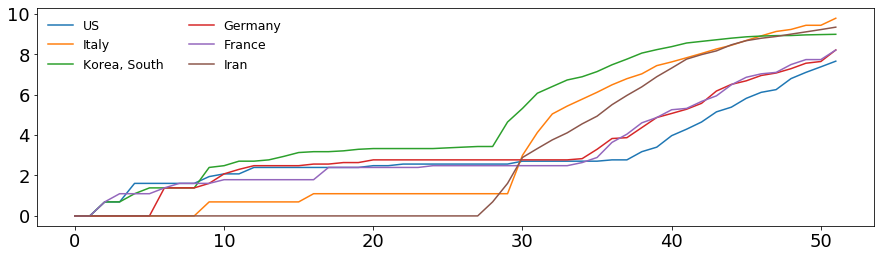

In [8]:
countries = ['Mainland China', 'US', 'Italy', 'Korea, South', 'Germany']
countries = ['US', 'Italy', 'Korea, South', 'Germany', 'France', 'Iran']
display(lin_df[['date_count'] + countries].tail(7))

fig, ax = plt.subplots(figsize=(15, 4))
for country in countries:
    ax.plot(log_df.date_count, log_df[country], label=country)
ax.legend(frameon=False, ncol=2, fontsize='x-small')

(14, 2)


Country/Region,date_count,US
2/28/20,37,16
2/29/20,38,24
3/1/20,39,30
3/2/20,40,53
3/3/20,41,73
3/4/20,42,104
3/5/20,43,172
3/6/20,44,217
3/7/20,45,336
3/8/20,46,452


Intercept: [-10.36047912]
Slope: [[0.35678213]] [[1.42872456]]


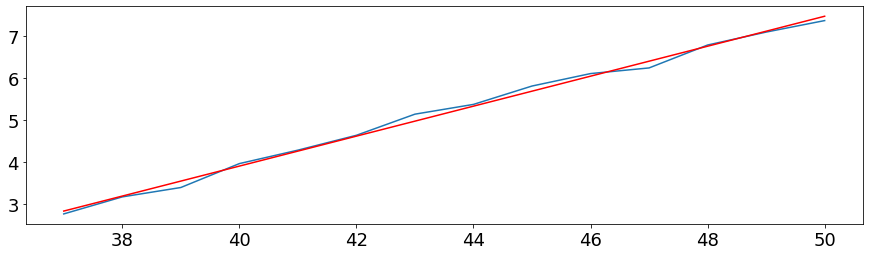

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

country = 'US'
df = lin_df[['date_count', country]].copy()
df = df[df.date_count >= 37]
df = df.head(df.shape[0]-1)
#df = df[df.date_count <= 20]
print(df.shape)
display(df)

x = df.date_count.values.reshape(-1, 1)
y = df[country].values.reshape(-1, 1)
y = np.log(y)
regressor = LinearRegression()
regressor.fit(x, y)
y_fit = regressor.predict(x)

print('Intercept:', regressor.intercept_)
print('Slope:', regressor.coef_, np.exp(regressor.coef_))

plt.figure(figsize=(15, 4))
plt.plot(x, y)
plt.plot(x, y_fit, color='red')
plt.show()

In [10]:
x_fut = x.copy()
x_fut -= x.min()
x_fut += x.max()
y_fut = regressor.predict(x_fut)
print(y_fut)
y_fut = np.exp(y_fut)
mat = np.c_[x_fut, y_fut].astype(int)
print(mat)

[[ 7.47862727]
 [ 7.83540939]
 [ 8.19219152]
 [ 8.54897365]
 [ 8.90575578]
 [ 9.26253791]
 [ 9.61932003]
 [ 9.97610216]
 [10.33288429]
 [10.68966642]
 [11.04644854]
 [11.40323067]
 [11.7600128 ]
 [12.11679493]]
[[    50   1769]
 [    51   2528]
 [    52   3612]
 [    53   5161]
 [    54   7374]
 [    55  10535]
 [    56  15052]
 [    57  21506]
 [    58  30726]
 [    59  43899]
 [    60  62720]
 [    61  89610]
 [    62 128029]
 [    63 182918]]
